In [60]:
import numpy as np
import openml
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import optuna

In [3]:
# Abalone https://www.openml.org/search?type=data&status=active&id=43611
dataset = openml.datasets.get_dataset(43611)

data, _, _, attribute_names = dataset.get_data(target=None)
data.dropna(inplace=True)
data.drop(columns=["id"], inplace=True)

X, y = data[data.columns.drop("class")], data["class"]

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   thickness  683 non-null    uint8  
 1   size       683 non-null    uint8  
 2   shape      683 non-null    uint8  
 3   adhesion   683 non-null    uint8  
 4   single     683 non-null    uint8  
 5   nuclei     683 non-null    float64
 6   chromatin  683 non-null    uint8  
 7   nucleoli   683 non-null    uint8  
 8   mitosis    683 non-null    uint8  
dtypes: float64(1), uint8(8)
memory usage: 16.0 KB


In [4]:
data.head()

,thickness,size,shape,adhesion,single,nuclei,chromatin,nucleoli,mitosis,class
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0


In [5]:
f"{y.unique()=}", y.info()

<class 'pandas.core.series.Series'>
Index: 683 entries, 0 to 698
Series name: class
Non-Null Count  Dtype
--------------  -----
683 non-null    uint8
dtypes: uint8(1)
memory usage: 6.0 KB


('y.unique()=array([0, 1], dtype=uint8)', None)

array([[<Axes: xlabel='thickness', ylabel='thickness'>,
        <Axes: xlabel='size', ylabel='thickness'>,
        <Axes: xlabel='shape', ylabel='thickness'>,
        <Axes: xlabel='adhesion', ylabel='thickness'>,
        <Axes: xlabel='single', ylabel='thickness'>,
        <Axes: xlabel='nuclei', ylabel='thickness'>,
        <Axes: xlabel='chromatin', ylabel='thickness'>,
        <Axes: xlabel='nucleoli', ylabel='thickness'>,
        <Axes: xlabel='mitosis', ylabel='thickness'>,
        <Axes: xlabel='class', ylabel='thickness'>],
       [<Axes: xlabel='thickness', ylabel='size'>,
        <Axes: xlabel='size', ylabel='size'>,
        <Axes: xlabel='shape', ylabel='size'>,
        <Axes: xlabel='adhesion', ylabel='size'>,
        <Axes: xlabel='single', ylabel='size'>,
        <Axes: xlabel='nuclei', ylabel='size'>,
        <Axes: xlabel='chromatin', ylabel='size'>,
        <Axes: xlabel='nucleoli', ylabel='size'>,
        <Axes: xlabel='mitosis', ylabel='size'>,
        <Axes: xlabel=

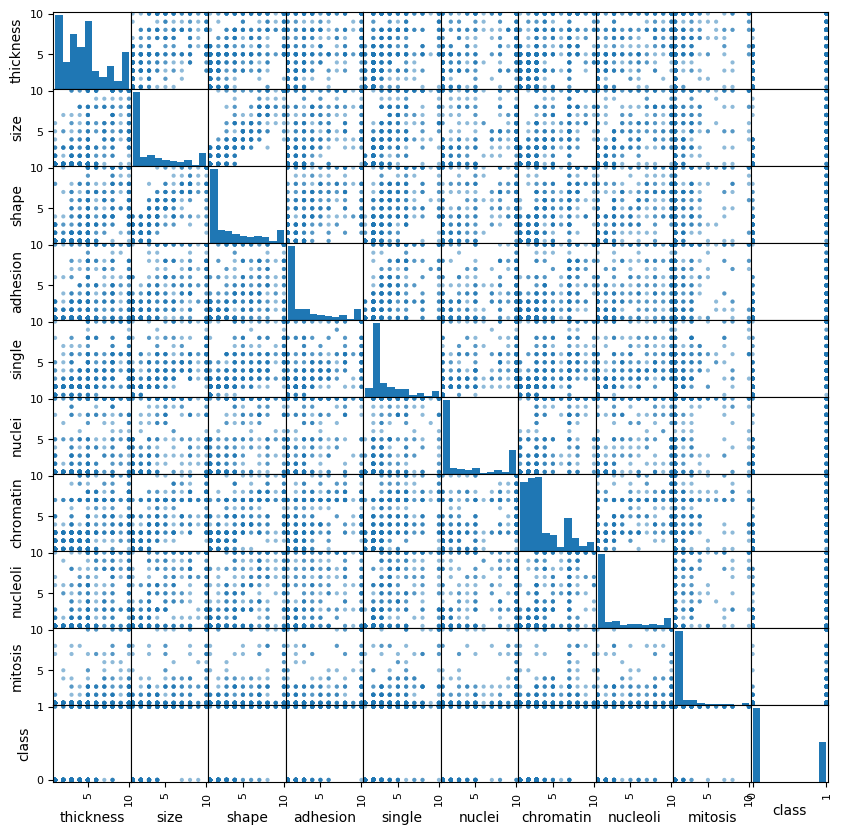

In [6]:
pd.plotting.scatter_matrix(data, figsize=(10, 10))

In [7]:
corr = X.corr()
corr

,thickness,size,shape,adhesion,single,nuclei,chromatin,nucleoli,mitosis
thickness,1.000000,0.642481,0.653470,0.487829,0.523596,0.593091,0.553742,0.534066,0.350957
size,0.642481,1.000000,0.907228,0.706977,0.753544,0.691709,0.755559,0.719346,0.460755
shape,0.653470,0.907228,1.000000,0.685948,0.722462,0.713878,0.735344,0.717963,0.441258
adhesion,0.487829,0.706977,0.685948,1.000000,0.594548,0.670648,0.668567,0.603121,0.418898
single,0.523596,0.753544,0.722462,0.594548,1.000000,0.585716,0.618128,0.628926,0.480583
nuclei,0.593091,0.691709,0.713878,0.670648,0.585716,1.000000,0.680615,0.584280,0.339210
chromatin,0.553742,0.755559,0.735344,0.668567,0.618128,0.680615,1.000000,0.665602,0.346011
nucleoli,0.534066,0.719346,0.717963,0.603121,0.628926,0.584280,0.665602,1.000000,0.433757
mitosis,0.350957,0.460755,0.441258,0.418898,0.480583,0.339210,0.346011,0.433757,1.000000


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((546, 9), (137, 9), (546,), (137,))

In [41]:
def own_cross_val_score(model) -> np.ndarray:
    scores = np.zeros(5)

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        xtr = X_train.iloc[train_index, :]
        ytr = y_train.iloc[train_index]

        model.fit(xtr, ytr)

        xte = X_train.iloc[test_index, :]
        yte = y_train.iloc[test_index]
        probs = model.predict_proba(xte)[:, 1]
        threshold = 0.5
        preds = (probs >= threshold).astype(int)

        scores[i] = accuracy_score(yte, preds)

    return scores


# LogisticRegression

In [10]:
def objective_lr(trial):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    solver = trial.suggest_categorical("solver", ['lbfgs', 'liblinear', 'saga'])
    max_iter = trial.suggest_int("max_iter", 100, 1000)

    lr_model = LogisticRegression(C=C, solver=solver, max_iter=max_iter, random_state=42)

    score = own_cross_val_score(lr_model).mean()
    return score


In [42]:
lr_study = optuna.create_study(study_name='LogisticRegression', direction='maximize', sampler=optuna.samplers.RandomSampler(42))
lr_study.optimize(objective_lr, n_trials=100)

[I 2025-11-20 22:09:57,343] A new study created in memory with name: LogisticRegression
[I 2025-11-20 22:09:57,549] Trial 0 finished with value: 0.9707089241034195 and parameters: {'C': 0.0745934328572655, 'solver': 'lbfgs', 'max_iter': 240}. Best is trial 0 with value: 0.9707089241034195.
[I 2025-11-20 22:09:57,664] Trial 1 finished with value: 0.9139449541284405 and parameters: {'C': 0.0060252157362038605, 'solver': 'liblinear', 'max_iter': 737}. Best is trial 0 with value: 0.9707089241034195.
[I 2025-11-20 22:09:57,829] Trial 2 finished with value: 0.9578815679733111 and parameters: {'C': 0.001267425589893723, 'solver': 'lbfgs', 'max_iter': 263}. Best is trial 0 with value: 0.9707089241034195.
[I 2025-11-20 22:09:57,915] Trial 3 finished with value: 0.9157297748123436 and parameters: {'C': 0.008260808399079604, 'solver': 'liblinear', 'max_iter': 362}. Best is trial 0 with value: 0.9707089241034195.
/home/dom/python_global_venvs/ML/venv/lib64/python3.11/site-packages/sklearn/linear_m

In [43]:
lr_study.best_params

{'C': 0.0745934328572655, 'solver': 'lbfgs', 'max_iter': 240}

# KNN


In [15]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 15)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)

    score = own_cross_val_score(model).mean()
    return score

In [44]:
knn_study = optuna.create_study(study_name='KNN', direction='maximize', sampler=optuna.samplers.RandomSampler(42))
knn_study.optimize(objective_knn, n_trials=100)

[I 2025-11-20 22:10:12,275] A new study created in memory with name: KNN
[I 2025-11-20 22:10:12,411] Trial 0 finished with value: 0.9725771476230193 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.9725771476230193.
[I 2025-11-20 22:10:12,501] Trial 1 finished with value: 0.9670558798999167 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.9725771476230193.
[I 2025-11-20 22:10:12,539] Trial 2 finished with value: 0.9597164303586322 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.9725771476230193.
[I 2025-11-20 22:10:12,574] Trial 3 finished with value: 0.9743953294412011 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 3 with value: 0.9743953294412011.
[I 2025-11-20 22:10:12,610] Trial 4 finished with value: 0.9725437864887407 and parameters: {'n_neighbors

In [45]:
knn_study.best_params

{'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean'}

# Assessment and model selection

In [46]:
# re-train with the best params to measure statistical difference
lr_model = LogisticRegression(**lr_study.best_params)
knn_model = KNeighborsClassifier(**knn_study.best_params)

lr_score = own_cross_val_score(lr_model).mean()
knn_score = own_cross_val_score(knn_model)

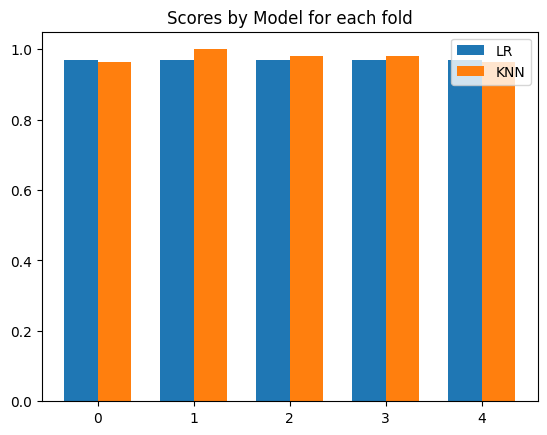

In [50]:
ax = plt.subplots()[1]

fold_numbers = np.arange(5)
width = 0.35

ax.bar(fold_numbers - width/2, lr_score, width, label="LR")
ax.bar(fold_numbers + width/2, knn_score, width, label="KNN")

ax.set_title("Scores by Model for each fold")
ax.legend()

plt.show()

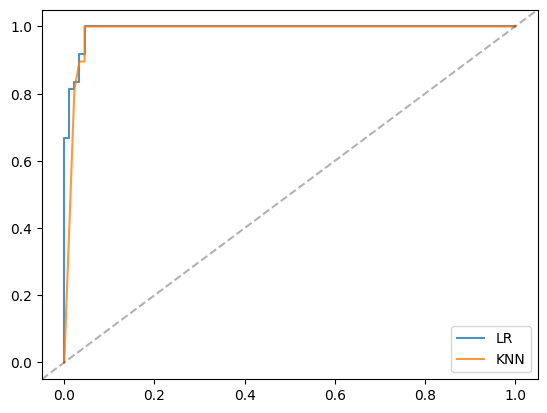

In [67]:
ax = plt.subplots()[1]

for mname, model in [("LR", lr_model), ("KNN", knn_model)]:
    probs = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _thresholds = roc_curve(y_test, probs)
    ax.plot(fpr, tpr, label=mname, alpha=0.8)

ax.axline((0, 0), (1, 1), c="k", linestyle="--", alpha=0.3)
ax.legend()

plt.show()

In [38]:
# null Hyp: no difference between the models
diffs = lr_score - knn_score
original_diff_mean = np.abs(diffs.mean())

print(f"{diffs=}\n{original_diff_mean=}")

# permutation test
means = np.zeros(100000)
for i in range(means.shape[0]):
    mul = np.random.choice([-1, 1], size=diffs.shape)
    mean = np.dot(diffs, mul) / diffs.shape[0]
    means[i] = mean

p = (np.abs(means) >= original_diff_mean).sum() / len(means)

mean_2_5, mean_9_75 = np.percentile(means, [2.5, 97.5])
print(f"95% CI: [{mean_2_5}, {mean_9_75}]")
nullHyp = mean_2_5 < 0 < mean_9_75
print(f"is zero in CI: {nullHyp}")
print(f"Can we reject null Hypothesis? {'no.' if nullHyp else 'yes.'}")
print(f"p-value = {p}")

diffs=array([ 0.00707256, -0.02929108, -0.01094245, -0.01094245,  0.00740617])
original_diff_mean=0.007339449541284448
95% CI: [-0.013130942452043382, 0.013130942452043382]
is zero in CI: True
Can we reject null Hypothesis? no.
p-value = 0.37502
